In [11]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

In [12]:
def count_files_in_subdirs(directory, set_name):
    # Initialize an empty dictionary to hold the count of files for each subdirectory.
    counts = {}

    # Iterate over each item in the given directory.
    for item in os.listdir(directory):
        # Construct the full path to the item.
        item_path = os.path.join(directory, item)

        # Check if the item is a directory.
        if os.path.isdir(item_path):
            # Count the number of files in the subdirectory and add it to the dictionary.
            counts[item] = len(os.listdir(item_path))

    # Convert the counts dictionary to a DataFrame for easy viewing and analysis.
    # The index of the DataFrame is set to the provided set name.
    df = pd.DataFrame(counts, index=[set_name])
    return df


In [13]:
train_dir = '/Users/abhishekwaghchaure/Desktop/PWSkillsDataScience/DataSets/Fer2013/test'
test_dir = '/Users/abhishekwaghchaure/Desktop/PWSkillsDataScience/DataSets/Fer2013/train'

# Count the files in the subdirectories of the training directory and print the result.
train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

# Count the files in the subdirectories of the testing directory and print the result.
test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)

       happy   sad  fear  surprise  neutral  angry
train   1774  1247  1024       831     1233    958
      happy   sad  fear  surprise  neutral  angry
test   7215  4830  4097      3171     4965   3995


<Axes: >

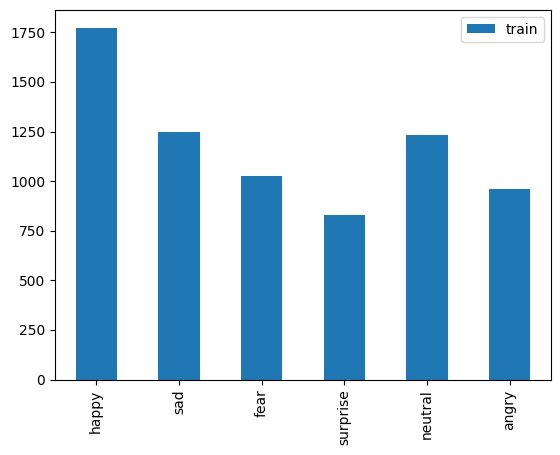

In [14]:
train_count.transpose().plot(kind='bar')

In [15]:
img_width, img_height = 48, 38
batch_size = 64
epochs = 10
num_classes = 6

<Axes: >

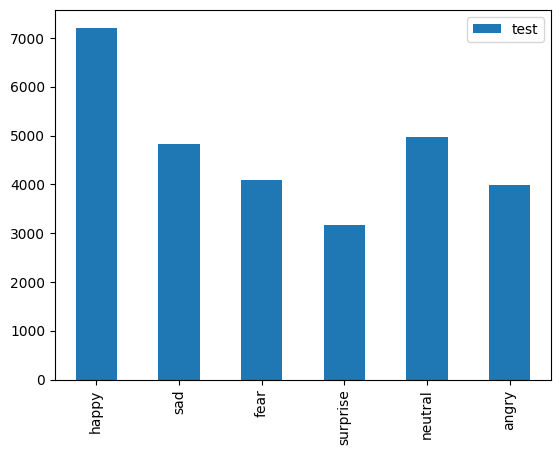

In [16]:
test_count.transpose().plot(kind='bar')

In [17]:
emotions = os.listdir(train_dir)
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[12])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.grid()
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')


AttributeError: can't set attribute 'mode'

<Figure size 1500x1000 with 0 Axes>

In [18]:
# Define paths to the train and validation directories
train_data_dir = '/Users/abhishekwaghchaure/Desktop/PWSkillsDataScience/DataSets/Fer2013/train'
test_data_dir = '/Users/abhishekwaghchaure/Desktop/PWSkillsDataScience/DataSets/Fer2013/test'
# validation_data_dir = '/content/emotion_detection_project/datasets/raw/test'

# Set some parameters
img_width, img_height = 48, 48  # Size of images
batch_size = 64
epochs = 10
num_classes = 6  # Update this based on the number of your classes


# Initializing the ImageDataGenerator with data augmentation options for the training set
data_generator = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixel values from [0, 255] to [0, 1]
    rotation_range=40,  # Degree range for random rotations
    width_shift_range=0.2,  # Range (as a fraction of total width) for random horizontal shifts
    height_shift_range=0.2,  # Range (as a fraction of total height) for random vertical shifts
    shear_range=0.2,  # Shearing intensity (shear angle in counter-clockwise direction)
    zoom_range=0.2,  # Range for random zoom
    horizontal_flip=True,  # Randomly flip inputs horizontally
    fill_mode='nearest',  # Strategy to fill newly created pixels, which can appear after a rotation or a width/height shift
    validation_split=0.2  # Set the validation split; 20% of the data will be used for validation
)

test_data_generator = ImageDataGenerator(rescale=1./255)


# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
    )

Found 22619 images belonging to 6 classes.
Found 5654 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


In [ ]:
img_width, img_height = 48, 48
classes = 6

#Initialising the CNN
model = tf.keras.models.Sequential()

# Adding convolutional layers with activations on separate lines
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(img_width, img_height, 1)))
model.add(tf.keras.layers.Activation('relu'))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))

model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(tf.keras.layers.Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(classes))
model.add(tf.keras.layers.Activation('softmax'))

/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-10-13 15:03:42.722355: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-10-13 15:03:42.722404: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-10-13 15:03:42.722427: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-10-13 15:03:42.722678: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-13 15:03:42.722706: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.c

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    epochs=60,
    validation_data=validation_generator)

In [ ]:
def plot_training_history(history):
 
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

In [ ]:
plot_training_history(history)

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))


In [ ]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=int(np.ceil(test_generator.samples/test_generator.batch_size))), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [ ]:
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

class_indices = test_generator.class_indices
Emotion_Classes = [key.capitalize() for key in class_indices.keys()]
print(Emotion_Classes)

def plot_predictions(model, test_generator, Emotion_Classes, num_images=10):
    # Randomly select a batch and images within the batch
    Random_batch = np.random.randint(0, len(test_generator) - 1)
    Random_Img_Index = np.random.randint(0, test_generator.batch_size - 1, num_images)

    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 15), subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        # Get random image and label from the selected batch
        Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
        Random_Img_resized = resize(Random_Img, (224, 224), anti_aliasing=True)  # Resize for MobileNet
        
        # Get the true label and model prediction
        Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])  # True label
        Model_Prediction = np.argmax(model.predict(Random_Img_resized.reshape(1, 224, 224, 3), verbose=0))  # Prediction

        # Display the image
        ax.imshow(Random_Img_resized)

        # Set title color based on correct/incorrect prediction
        if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
            color = "green"  # Correct prediction
        else:
            color = "red"  # Incorrect prediction

        # Set the title to show true vs predicted labels
        ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color, fontsize=18)

    plt.tight_layout()
    plt.show()

# Call the function to plot predictions
plot_predictions(model, test_generator, Emotion_Classes)

## MobileNet

In [1]:
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import f1_score

precision = Precision()
recall = Recall()

2024-10-13 08:20:27.460630: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-10-13 08:20:27.460654: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-10-13 08:20:27.460661: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-10-13 08:20:27.460676: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-13 08:20:27.460687: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
train_data_dir = '/Users/abhishekwaghchaure/Desktop/PWSkillsDataScience/DataSets/Fer2013/train'
test_data_dir = '/Users/abhishekwaghchaure/Desktop/PWSkillsDataScience/DataSets/Fer2013/test'

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input

    # Step 1: Set the image size for MobileNet and number of classes
img_width, img_height = 224, 224  
input_shape = (img_width, img_height, 3)  
classes = 6  


base_model = MobileNet(input_shape=input_shape, include_top=False, weights='imagenet')

    # Step 3: Freeze the base model layers (optional, can fine-tune later)
base_model.trainable = False

    # Step 4: Add custom classification layers on top of MobileNet
x = base_model.output
x = GlobalAveragePooling2D()(x)  
x = Dense(1024, activation='relu')(x) 
x = Dropout(0.5)(x) 
predictions = Dense(classes, activation='softmax')(x) 

    # Step 5: Define the full model

model = Model(inputs=base_model.input, outputs=predictions)
    # Step 6: Compile the model with a suitable optimizer, loss, and metrics
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', precision, recall])

    # Step 7: Print model summary
model.summary()

    # Step 8: Prepare the data (train, validation, test)
    # Using ImageDataGenerator for data augmentation and rescaling images
    # train_datagen = ImageDataGenerator(
    #     rescale=1./255,  # Rescale the pixel values from [0, 255] to [0, 1]
    #     rotation_range=40,  # Degree range for random rotations
    #     width_shift_range=0.2,  # Range (as a fraction of total width) for random horizontal shifts
    #     height_shift_range=0.2,  # Range (as a fraction of total height) for random vertical shifts
    #     shear_range=0.2,  # Shearing intensity (shear angle in counter-clockwise direction)
    #     zoom_range=0.2,  # Range for random zoom
    #     horizontal_flip=True,  # Randomly flip inputs horizontally
    #     fill_mode='nearest',  # Strategy to fill newly created pixels, which can appear after a rotation or a width/height shift
    #     validation_split=0.2 # Randomly flip images horizontally
    # )

    # test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for test/validation data

    # # Step 9: Load the training, validation, and test data
    # train_generator = train_datagen.flow_from_directory(
    #     train_data_dir,  # Path to your training data
    #     target_size=(img_width, img_height),  # Resize all images to 224x224
    #     batch_size=32,  # Batch size
    #     class_mode='categorical'  # Categorical labels (one-hot encoding)
    # )

    # validation_generator = test_datagen.flow_from_directory(
    #     train_data_dir,  # Path to your validation data
    #     target_size=(img_width, img_height),  # Resize to 224x224
    #     batch_size=32,
    #     class_mode='categorical'
    # )

    # test_generator = test_datagen.flow_from_directory(
    #     test_data_dir,  # Path to your test data
    #     target_size=(img_width, img_height),  # Resize to 224x224
    #     batch_size=32,
    #     class_mode='categorical'
    # )

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # MobileNet-specific preprocessing
    width_shift_range=0.2,  # Horizontal shift for augmentation
    rotation_range=30,  # Random rotations for augmentation
    height_shift_range=0.2,  # Vertical shift for augmentation
    zoom_range=0.2,  # Random zoom for augmentation
    shear_range=0.2,  # Shearing for augmentation
    horizontal_flip=True,  # Horizontal flip for augmentation
    fill_mode='nearest'  # Filling in missing pixels
    )

    # Validation/test data generator without augmentation, just preprocessing for MobileNet
test_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input  # Only MobileNet-specific preprocessing
    )

    # Train generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # Directory containing training data
        target_size=(img_width, img_height),# Resize images to 224x224
        batch_size=32,  # Set batch size based on your memory capacity
        class_mode='categorical',  # For multi-class classification
        shuffle=True  # Shuffle training data
    )

    # Validation generator
validation_generator = test_datagen.flow_from_directory(
        test_generator,  # Directory containing validation data
        target_size=(img_width, img_height),# Resize images to 224x224
        batch_size=32,  # Set batch size based on your memory capacity
        class_mode='categorical',  # For multi-class classification
        shuffle=False  # No shuffling for validation data
    )
    
    # Test gene
test_generator = test_datagen.flow_from_directory(
        test_data_dir,  # Path to your test data
        target_size=(img_width, img_height),  # Resize to 224x224
        batch_size=32,
        class_mode='categorical'
    )
    

    # Step 10: Train the model
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        epochs=60
    )

    # Step 11: Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
    print(f'Test accuracy: {test_acc:.4f}') 
    print(f'Test accuracy: {test_acc:.4f}') 
    print(f'Test accuracy: {test_acc:.4f}')


2024-10-13 08:10:56.135756: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-10-13 08:10:56.135806: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-10-13 08:10:56.135818: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-10-13 08:10:56.135839: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-13 08:10:56.135852: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
import matplotlib.pyplot as plt

def plot_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    # Add checks for precision and recall in the history (they may not always be available)
    precision = history.history.get("precision", [])
    recall = history.history.get("recall", [])

    epochs = range(len(loss))

    plt.figure(figsize=(15, 5))

    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, loss, label="Training Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, accuracy, label="Training Accuracy")
    plt.plot(epochs, val_accuracy, label="Validation Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Plot precision and recall if available
    if precision and recall:
        plt.subplot(1, 3, 3)
        plt.plot(epochs, precision, label="Precision")
        plt.plot(epochs, recall, label="Recall")
        plt.title("Precision and Recall")
        plt.xlabel("Epochs")
        plt.ylabel("Value")
        plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plot_curves function after training
plot_curves(history)


In [ ]:
MobileNet_Predictions = model.predict(test_generator)

# Choosing highest probalbilty class in every prediction 
MobileNet_Predictions = np.argmax(MobileNet_Predictions, axis=1)

In [ ]:
history = history
final_accuracy = history.history['accuracy'][-1]
final_precision = history.history['precision'][-1]
final_recall = history.history['recall'][-1]
final_val_loss = history.history['val_loss'][-1]
final_f1_score = (2 * final_precision * final_recall) / (final_precision + final_recall)

print("*" * 8, "Final Metrics", "*" * 8)
print("Final Accuracy        : {:.2%}".format(final_accuracy))
print("Final Precision       : {:.2%}".format(final_precision))
print("Final Recall          : {:.2%}".format(final_recall))
print("Final Validation Loss : {:.4f}".format(final_val_loss))
print("Final F1 Score        : {:.3}".format(final_f1_score))

In [ ]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

fig, ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_generator.labels, MobileNet_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels', fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('MobileNet Confusion Matrix', fontsize=20, fontweight='bold')


In [ ]:
class_indices = test_generator.class_indices
Emotion_Classes = [key.capitalize() for key in class_indices.keys()]
print(Emotion_Classes)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

# Assuming 'test_generator' contains your test image data and 'Emotion_Classes' is a list of your class labels

def plot_predictions(model, test_generator, Emotion_Classes, num_images=10):
    # Randomly select a batch and images within the batch
    Random_batch = np.random.randint(0, len(test_generator) - 1)
    Random_Img_Index = np.random.randint(0, test_generator.batch_size - 1, num_images)

    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 15), subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        # Get random image and label from the selected batch
        Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
        Random_Img_resized = resize(Random_Img, (224, 224), anti_aliasing=True)  # Resize for MobileNet
        
        # Get the true label and model prediction
        Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])  # True label
        Model_Prediction = np.argmax(model.predict(Random_Img_resized.reshape(1, 224, 224, 3), verbose=0))  # Prediction

        # Display the image
        ax.imshow(Random_Img_resized)

        # Set title color based on correct/incorrect prediction
        if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
            color = "green"  # Correct prediction
        else:
            color = "red"  # Incorrect prediction

        # Set the title to show true vs predicted labels
        ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color, fontsize=18)

    plt.tight_layout()
    plt.show()

# Call the function to plot predictions
plot_predictions(model, test_generator, Emotion_Classes)